In [1]:
import numpy as np
import os,re
import tensorflow as tf
from tensorflow import keras
import utils
from GSGM import GSGM_Model as GSGM
from tensorflow.keras.callbacks import ModelCheckpoint
from lorentz_equivariance_test import *
import horovod.tensorflow.keras as hvd
from equivariant_network import LEGNN
from copy import deepcopy

tf.random.set_seed(1233)

In [2]:
hvd.init()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()], 'GPU')

In [3]:
config = utils.LoadJson('config.json')
model = GSGM(config = config)

event_count = int(1e4)
num_feat = config['NUM_FEAT']

2023-05-29 17:53:55.944712: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 17:53:56.949436: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78933 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:03:00.0, compute capability: 8.0


In [4]:
boosts = []
errors = []
for i in range(20):
    boost = 10 ** ((i - 10.) / 2.) + 1.
    rapidity = np.arccosh(boost)
    
    tf.random.set_seed(i * 1000)
    p1 = model.PCSampler(event_count, 2).numpy()
    particle1_gen = [p1]
    particle1_gen = np.concatenate(particle1_gen)
    output1_particle = boost_y(particle1_gen, rapidity)

    tf.random.set_seed(i * 1000)
    p2 = model.PCSampler(event_count, 2, boost = lambda x: boost_y(x, rapidity)).numpy()
    particle2_gen = [p2]
    particle2_gen = np.concatenate(particle2_gen)
    output2_particle = particle2_gen

    boosts.append(boost)
    errors.append(np.sqrt(np.mean((output2_particle - output1_particle) ** 2)))

2023-05-29 17:54:00.036128: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Time for sampling 10000 events is 14.020493030548096 seconds
Time for sampling 10000 events is 10.668787956237793 seconds
Time for sampling 10000 events is 10.598333597183228 seconds
Time for sampling 10000 events is 10.540629863739014 seconds
Time for sampling 10000 events is 10.516549348831177 seconds
Time for sampling 10000 events is 10.38260793685913 seconds
Time for sampling 10000 events is 10.38255000114441 seconds
Time for sampling 10000 events is 10.41592264175415 seconds
Time for sampling 10000 events is 10.430174827575684 seconds
Time for sampling 10000 events is 10.437040090560913 seconds
Time for sampling 10000 events is 10.953637838363647 seconds
Time for sampling 10000 events is 10.95751690864563 seconds
Time for sampling 10000 events is 10.99308729171753 seconds
Time for sampling 10000 events is 10.951565742492676 seconds
Time for sampling 10000 events is 10.998296737670898 seconds
Time for sampling 10000 events is 11.123565196990967 seconds
Time for sampling 10000 event

In [10]:
model = LEGNN(4, [4, 1], [32, 32], num_layers = 4)

boosts = []
errors = []
for i in range(200):
    boost = 10 ** ((i / 10. - 10.) / 2.) + 1.
    rapidity = np.arccosh(boost)
    
    p = tf.random.normal([event_count, 10, 4])
    t = tf.random.uniform([event_count, 1])
    
    p1 = deepcopy(p)
    output1 = model([p1, t])
    output1_particle = boost_y(output1, rapidity)

    p2 = deepcopy(p)
    output2 = model([boost_y(p2, rapidity), t])
    output2_particle = output2

    boosts.append(boost)
    errors.append(np.sqrt(np.mean((output2_particle - output1_particle) ** 2)))

In [5]:
errors

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

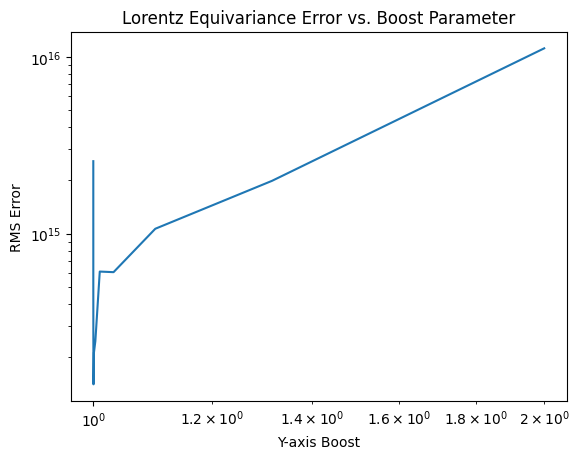

In [6]:
axes = plt.axes()
axes.set_xscale('log')
axes.set_yscale('log')
plt.title('Lorentz Equivariance Error vs. Boost Parameter')
plt.ylabel('RMS Error')
plt.xlabel('Y-axis Boost')
plt.plot(boosts, errors)
plt.show()

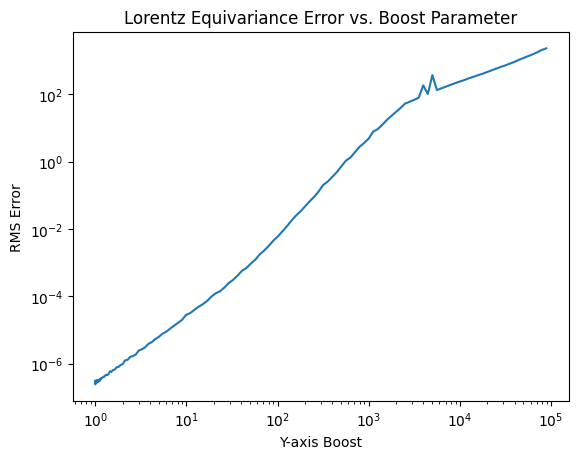

In [12]:
axes = plt.axes()
axes.set_xscale('log')
axes.set_yscale('log')
plt.title('Lorentz Equivariance Error vs. Boost Parameter')
plt.ylabel('RMS Error')
plt.xlabel('Y-axis Boost')
plt.plot(boosts, errors)
plt.show()